In [ ]:
# import os
# import zipfile

# def make_zip(folder_path, zip_path):
#     with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 zip_file.write(os.path.join(root, file),
#                                os.path.relpath(os.path.join(root, file),
#                                os.path.join(folder_path, '..')))

# # Usage
# folder_path = '/content/drive/MyDrive/ug26_3/Datasets/Segmentation/TNBC'  # replace with your folder path
# zip_path = '/content/drive/MyDrive/ug26_3/Datasets/Segmentation/TNBc.zip'  # replace with the desired zip file path
# make_zip(folder_path, zip_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, Add, Dropout, Concatenate, Conv2DTranspose, Dense, Reshape, Flatten, Softmax, Lambda, UpSampling2D, AveragePooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
!pip install tensorflow-wavelets
import tensorflow_wavelets.Layers.DWT as DWT
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

from tqdm import tqdm

from tensorflow.keras import backend as K
import time
import zipfile
import shutil

In [ ]:
base_path_drive = '/content/drive/MyDrive/ug26_3/Datasets/Segmentation/'
with zipfile.ZipFile(base_path_drive+"TNBC.zip","r") as zip_ref:
     zip_ref.extractall('/content/TNBC')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# title = "MONUSEG_LAYERS_MULTIPLIED_BOTTLENECK_ACT9/"
# models_dir = '/content/drive/MyDrive/ug26_3/Models/Segmentation/' + title

dataset_path = '/content/TNBC/'

train_path = '/content/TNBC/TNBC/Train/'
test_path  = '/content/TNBC/TNBC/Test/'

In [ ]:
tissue_train = sorted(os.listdir(os.path.join(train_path, "tissue")))
mask_train = sorted(os.listdir(os.path.join(train_path, "mask")))

In [ ]:
tissue_train_count = len(tissue_train)
mask_train_count = len(mask_train)

print("Number of data samples in tissue_train: ", tissue_train_count)
print("Number of data samples in mask_train: ", mask_train_count)


Number of data samples in tissue_train:  30
Number of data samples in mask_train:  30


In [ ]:
tissue_test = sorted([
    file for file in os.listdir(os.path.join(test_path, "tissue"))
    if file.lower().endswith('.png')
])
mask_test = sorted(os.listdir(os.path.join(test_path, "mask")))

In [ ]:
tissue_test_count = len(tissue_test)
mask_test_count = len(mask_test)

print("Number of data samples in tissue_test: ", tissue_test_count)
print("Number of data samples in mask_test: ", mask_test_count)


Number of data samples in tissue_test:  20
Number of data samples in mask_test:  20


In [ ]:
def create_train(tissue_train, mask_train,batch):
  def parse_images(tissue_train, mask_train):

    tissue_file_str = tf.strings.join([train_path, "tissue/", tissue_train])
    mask_file_str = tf.strings.join([train_path, "mask/", mask_train])

    tissue_image = tf.io.read_file(tissue_file_str)
    mask_image = tf.io.read_file(mask_file_str)

    tissue_image = tf.image.decode_png(tissue_image, channels=3)
    mask_image = tf.image.decode_png(mask_image, channels=1)

    tissue_image = tf.image.resize(tissue_image, [512, 512])
    mask_image = tf.image.resize(mask_image, [512, 512])


    # mask_image = np.array(mask_image)
    # _, mask_image = cv2.threshold(mask_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # mask_image = tf.where(mask_image >= 0.5, 255, 0)



    tissue_image = tf.cast(tissue_image, tf.float32) / 255.0
    mask_image = tf.cast(mask_image, tf.float32) / 255.0

    return tissue_image, mask_image


  dataset = tf.data.Dataset.from_tensor_slices((tissue_train, mask_train))
  dataset = dataset.map(parse_images)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()

  return dataset

In [ ]:
def create_test(tissue_test, mask_test,batch):
  def parse_images(tissue_test, mask_test):

    tissue_file_str = tf.strings.join([test_path, "tissue/", tissue_test])
    mask_file_str = tf.strings.join([test_path, "mask/", mask_test])

    tissue_image = tf.io.read_file(tissue_file_str)
    mask_image = tf.io.read_file(mask_file_str)

    tissue_image = tf.image.decode_png(tissue_image, channels=3)
    mask_image = tf.image.decode_png(mask_image, channels=1)

    tissue_image = tf.image.resize(tissue_image, [512, 512])
    mask_image = tf.image.resize(mask_image, [512, 512])

    # _, mask_image = cv2.threshold(mask_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # mask_image = tf.where(mask_image >= 0.5, 255, 0)


    tissue_image = tf.cast(tissue_image, tf.float32) / 255.0
    mask_image = tf.cast(mask_image, tf.float32) / 255.0

    return tissue_image, mask_image

  dataset = tf.data.Dataset.from_tensor_slices((tissue_test, mask_test))
  dataset = dataset.map(parse_images)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()

  return dataset

In [ ]:
TOTAL_TRAIN_SAMPLES = len(tissue_train)
TOTAL_TEST_SAMPLES = len(tissue_test)
BATCH_SIZE = 2

train_dataset = create_train(tissue_train, mask_train,BATCH_SIZE)
test_dataset = create_test(tissue_test, mask_test,BATCH_SIZE)

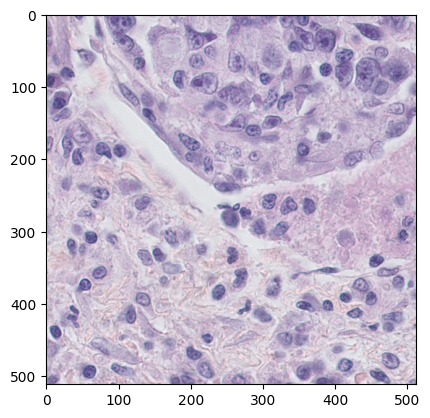

In [ ]:
it = iter(test_dataset)
tissue, mask = next(it)
plt.imshow(tissue[0])

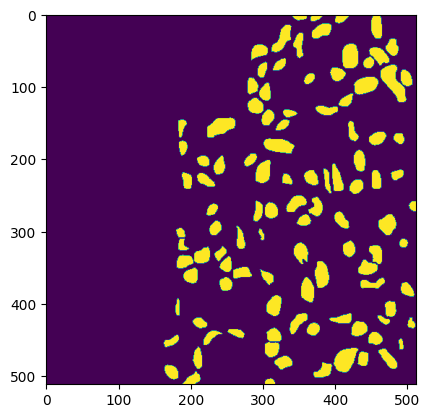

In [ ]:
it = iter(test_dataset)
tissue, mask = next(it)
plt.imshow(mask[1])

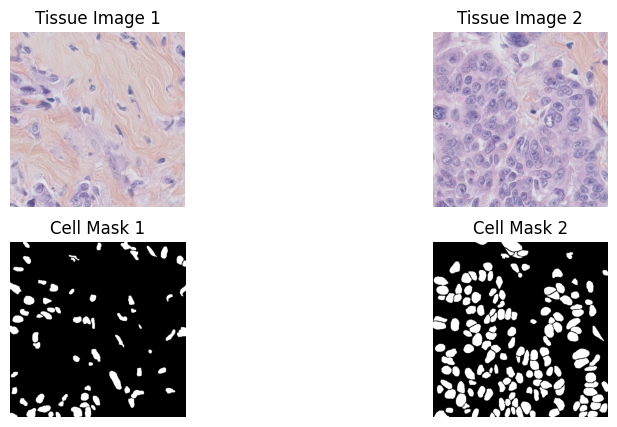

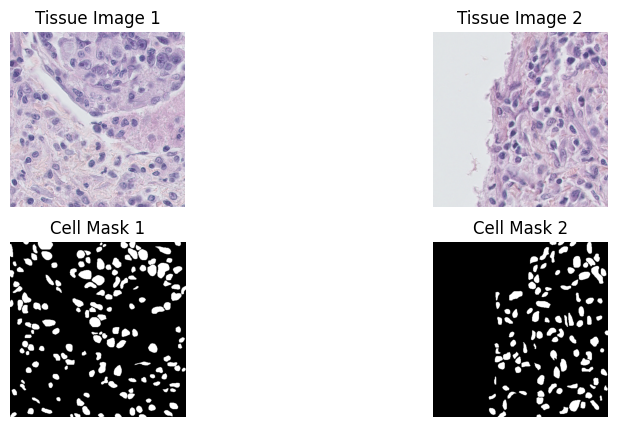

In [ ]:
def display_images(dataset):
    for image, mask in dataset.take(1):
        plt.figure(figsize=(10, 5))
        for i in range(len(image)):
            plt.subplot(2, len(image), i + 1)
            plt.imshow(image[i])
            plt.title('Tissue Image {}'.format(i + 1))
            plt.axis('off')

            plt.subplot(2, len(mask), len(mask) + i + 1)
            plt.imshow(mask[i][:, :, 0], cmap='gray')
            plt.title('Cell Mask {}'.format(i + 1))
            plt.axis('off')

        plt.show()


display_images(train_dataset)
display_images(test_dataset)

**MODEL**

*SE Block*

In [ ]:
class SqueezeExcitation(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(SqueezeExcitation, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.squeeze_conv = tf.keras.layers.Conv2D(
            filters=input_shape[-1] // self.reduction_ratio,
            kernel_size=(1, 1),
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=False
        )
        self.excitation_conv = tf.keras.layers.Conv2D(
            filters=input_shape[-1],
            kernel_size=(1, 1),
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False
        )
        super(SqueezeExcitation, self).build(input_shape)

    def call(self, inputs):
        x = self.global_pooling(inputs)
        x = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(x)
        x = self.squeeze_conv(x)
        x = self.excitation_conv(x)
        return inputs * x

    def compute_output_shape(self, input_shape):
        return input_shape

*Graph Layer*

In [ ]:
class NewGraphLayer:

  def __init__(self, n):
        self.n = n
        self.mask_matrix = tf.tile( tf.eye(n), [1, n])
        self.unmask_matrix = tf.constant([[int(j // n == i) for j in range(n ** 2)] for i in range(n)],dtype=tf.float32)
        self.unflatten_mat = tf.transpose(tf.reshape(tf.eye(n)*tf.expand_dims(tf.expand_dims(tf.eye(n), axis = -1), axis = -1), (n, n*n, n)), perm = [2,1,0])

  def custom_flatten(self,A):
        """
        A : (B, n,n, c)
        C : (B, n^2, c)
        """
        n = A.shape[1]
        B = tf.transpose(A, perm=[0,3,1,2])
        B = (B @  self.mask_matrix)*self.unmask_matrix
        B = tf.reduce_sum(B,axis=-2)
        C = tf.transpose(B, perm=[0,2,1])
        return C

  def custom_unflatten(self, A):
      """
      A : (B, n^2)
      C : (B, N, N)
      """
      C = tf.transpose((tf.matmul(A , self.unflatten_mat)),perm=[1,2,0])
      return C

  def sum_channels(self, flattened_nodes):
        """
        flattened_nodes : (B, N^2, C)
        x : (B, C)
        """
        x = tf.reduce_sum(flattened_nodes, axis = 1)
        x = tf.expand_dims(x, axis = 1)
        return x

  def compute_dot_products(self):
        """
        summed_vectors: (B, 1, C)
        node_features = (B, N^2, C)
        dot_products = (B, N^2)
        """
        dot_products = tf.reduce_sum(tf.multiply(self.node_features, self.summed_vectors), axis = -1)
        return dot_products

  def prune_channel_by_variance(self, feature_map): # feature_map = B x N x N x C
        variance_per_channel_vector = tf.math.reduce_variance(feature_map, axis = (1, 2), keepdims = True) # B x 1 x 1 x C
        # print(variance_per_channel_vector)
        # scaled_variance_per_channel_vector =  variance_per_channel_vector/ tf.reduce_max(variance_per_channel_vector, axis = (1,2,3), keepdims = True)
        # print(scaled_variance_per_channel_vector)
        mean_variance_per_sample = tf.reduce_mean(variance_per_channel_vector, axis = (1,2,3), keepdims = True) # (B,)
        # relu_mask = tf.keras.activations.relu((scaled_variance_per_channel_vector-mean_variance_per_sample)/tf.reduce_max(scaled_variance_per_channel_vector-mean_variance_per_sample, axis = (1,2,3), keepdims = True))
        # relu_mask_scaled = relu_mask / tf.reduce_max(relu_mask, axis = (1,2,3), keepdims = True)
        # print(mean_variance_per_sample)
        pruning_mask = tf.where(variance_per_channel_vector > mean_variance_per_sample, 1.0, 0.0)
        # print(relu_mask_scaled)
        # pruned_feature_map = feature_map * relu_mask_scaled
        pruned_feature_map = feature_map * pruning_mask

        # print(pruned_feature_map)
        return pruned_feature_map

  def create_graph_map(self, dot_products):
        map = self.custom_unflatten(dot_products)
        # map = tf.cast(map, tf.float32) / tf.reduce_max(map)
        # scaled_map = (map - tf.reduce_min(map)) / (tf.reduce_max(map) - tf.reduce_min(map))
        # min_values = tf.reduce_min(map, axis=(1, 2), keepdims=True)
        max_values = tf.reduce_max(map, axis=(1, 2), keepdims=True)
        # scaled_map = (map - min_values) / (max_values - min_values)
        map = tf.cast(map, tf.float32) / (max_values)
        return 2. * map
        # return map

  def __call__(self, input_data):
        self.input_data = input_data
        # self.pruned_data = self.prune_channel_by_variance(input_data)
        self.node_features =self.custom_flatten(self.input_data)
        self.summed_vectors = self.sum_channels(self.node_features)
        dot_products = self.compute_dot_products()
        map = self.create_graph_map(dot_products)
        return map

*Graph Attention Layer*

In [ ]:
class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, n, **kwargs):
        self.n = n
        super(GraphAttentionLayer, self).__init__(**kwargs)
    @tf.function
    def build(self, input_shape):
        self.phi_g = Conv2D(
            filters = input_shape[-1],
            kernel_size = (1, 1),
            strides = (1, 1),
            padding = "same"
        )
        self.theta_x = Conv2D(
            filters = input_shape[-1]*4,
            kernel_size = (1,1),
            strides = (1,1),
            padding = "same"
        )
        self.concatenate = Concatenate(axis = -1)
        self.psi = Conv2D(
            filters = 1,
            kernel_size = (1,1),
            padding = "same"
        )
        self.result = Conv2D(
            filters = input_shape[-1],
            kernel_size = (1,1),
            padding = "same"
        )
        self.multiply = tf.keras.layers.Multiply()
        self.bn =  tf.keras.layers.BatchNormalization()
        self.up = UpSampling2D(size = (2, 2))
        super(GraphAttentionLayer, self).build(input_shape)
    @tf.function
    def call(self, input_x, input_g):
        _, h, w, c = input_x.shape
        x = tf.reshape(input_x, (tf.shape(input_x)[0], h//2, w//2, c * 4))
        variance_per_channel_vector_x = tf.math.reduce_variance(x, axis = (1, 2), keepdims = True)
        mean_variance_per_sample_x = tf.reduce_mean(variance_per_channel_vector_x, axis = (1,2,3), keepdims = True)
        pruning_mask_x = tf.where(variance_per_channel_vector_x > mean_variance_per_sample_x, 1.0, 0.0)
        x = x * pruning_mask_x
        x = self.theta_x(x)
        variance_per_channel_vector_g = tf.math.reduce_variance(input_g, axis = (1, 2), keepdims = True)
        mean_variance_per_sample_g = tf.reduce_mean(variance_per_channel_vector_g, axis = (1,2,3), keepdims = True)
        pruning_mask_g = tf.where(variance_per_channel_vector_g > mean_variance_per_sample_g, 1.0, 0.0)
        input_g = input_g * pruning_mask_g
        g = self.phi_g(input_g)

        concat_inputs = self.concatenate([x, g])
        concat_inputs_activated = tf.keras.activations.relu(concat_inputs)
        a = NewGraphLayer(self.n)
        map = a(concat_inputs_activated)
        # # Assuming `map` has shape (batch_size, n, n)
        # batch_size = tf.shape(map)[0]

        # Calculate mean per sample
        # mean_per_sample = tf.reduce_mean(map, axis=(1, 2), keepdims=True)

        # # Threshold each sample in the batch separately
        # thresholded_map = tf.where(map > mean_per_sample, map, tf.zeros_like(map))
        map_expanded = tf.expand_dims(map, axis = -1)
        # map_expanded_ = tf.keras.activations.relu(tf.keras.activations.tanh(map_expanded))
        # concat_inputs_psi = self.psi(concat_inputs_activated)

        # weights = tf.keras.activations.sigmoid(concat_inputs_psi)
        map_upsampled = self.up(map_expanded)

        y = self.multiply([input_x, map_upsampled])
        y_res = self.result(y)

        y_bn = self.bn(y_res)

        return y_bn, map_upsampled, concat_inputs_activated

*Group Normalization*

In [ ]:
class GroupNormalization(tf.keras.layers.Layer):
    def __init__(self, groups=1, epsilon=1e-5):
        super(GroupNormalization, self).__init__()
        self.groups = groups
        self.epsilon = epsilon

    def build(self, input_shape):
        # Ensure that the number of channels is divisible by the number of groups
        assert input_shape[-1] % self.groups == 0

        # Create a scale parameter and a shift parameter for each group
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True
        )
        self.shift = self.add_weight(
            name='shift',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, height, width, channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

        # Reshape inputs to [batch_size, height, width, groups, channels_per_group]
        grouped_inputs = tf.reshape(inputs, [batch_size, height, width, self.groups, channels // self.groups])

        # Calculate mean and variance for each group independently
        mean = tf.reduce_mean(grouped_inputs, axis=[1, 2, 4], keepdims=True)
        variance = tf.reduce_mean(tf.square(grouped_inputs - mean), axis=[1, 2, 4], keepdims=True)

        # mean, variance = tf.nn.moments(grouped_inputs, [1, 2, 4], keepdims=True)

        # Normalize the input within each group
        normalized = (grouped_inputs - mean) / tf.sqrt(variance + self.epsilon)

        # Reshape back to the original shape
        normalized = tf.reshape(normalized, [batch_size, height, width, channels])

        # Apply scale and shift
        output = self.scale * normalized + self.shift
        return output


In [ ]:
class WeightedGlobalAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(WeightedGlobalAveragePooling2D, self).__init__(**kwargs)
        self.num_channels = num_channels
        # Create a trainable weight variable for each channel
        self.channel_weights = self.add_weight(name='channel_weights',
                                              shape=(num_channels,),
                                              initializer='ones',
                                              trainable=True)

    def call(self, inputs):
        # Calculate weighted global average pooling
        weighted_sum = tf.reduce_sum(inputs * self.channel_weights, axis=[1, 2])
        weighted_average = weighted_sum / tf.reduce_sum(self.channel_weights)
        return weighted_average

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_channels)

In [ ]:
def CombinedUpsampleLayer(inputs):
    _,H,W,C = inputs.shape
    # gaussian = UpSampling2D(size=(2, 2), interpolation="gaussian")(inputs)
    combined = UpSampling2D(size=(2, 2), interpolation="lanczos5")(inputs)
    # combined = tf.keras.layers.Add()([gaussian, lanczos])
    combined_attn = Conv2D(C, 1, padding="same")(combined)

    # Assuming you want to upsample to the original input size
    upsampled = Conv2DTranspose(C, (2, 2), strides=2, padding="same")(inputs)

    x = Concatenate()([combined_attn,upsampled])
    return x

In [ ]:
# @title Default title text
class FunctionalModel:
  def __init__(self):
    self.pre_trained_backbone =  tf.keras.applications.DenseNet121(
      include_top=False ,
      weights='imagenet' ,
      input_shape=(512, 512, 3))

  def conv_block(self,inputs, num_filters):
    x1 = Conv2D(num_filters//2, 5, padding="same")(inputs)
    x1 = GroupNormalization()(x1)
    x1 = Activation("relu")(x1)

    x2 = Conv2D(num_filters//2, 3, padding="same")(inputs)
    x2 = GroupNormalization()(x2)
    x2 = Activation("relu")(x2)

    x2 = Concatenate()([x1,x2])
    x2 = Conv2D(num_filters, 1, padding="same")(x2)

    x3 = Conv2D(num_filters, 1, padding="same")(inputs)
    x3 = GroupNormalization()(x3)
    x3 = Activation("relu")(x3)

    x3 = Concatenate()([x2,x3])

    x = Conv2D(num_filters, 3, padding="same")(x3)
    x = GroupNormalization()(x)
    x = Activation("relu")(x)

    return x


  def bridge_layer(self, x, num_filters):
    x_init = x

    x = Conv2D(num_filters, 4, padding="same")(x)
    x = GroupNormalization(groups=4)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 4, padding="same")(x)
    x = GroupNormalization(groups=4)(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs, skip_features, num_filters):
    x = CombinedUpsampleLayer(inputs)
    x = Concatenate()([x, skip_features])
    x = self.conv_block(x, num_filters)
    return x

  def get(self):

    inputs = self.pre_trained_backbone.input

    s1 = 'input_1'
    s2 = 'conv1/relu'
    s3 = 'pool2_relu'
    s4 = 'pool3_relu'

    # Encoder
    s1 = inputs
    s2 = self.pre_trained_backbone.get_layer(s2).output #256
    s3 = self.pre_trained_backbone.get_layer(s3).output #128
    s4 = self.pre_trained_backbone.get_layer(s4).output #64
    b = self.pre_trained_backbone.get_layer("pool4_relu").output  ## 32

    x1 = SqueezeExcitation()(s4)
    G1, map1, c1 = GraphAttentionLayer(n=32, name = "Graph1_64")(x1, b)
    # map1 = b

    # Decoder
    d1 = self.decoder_block(b,G1, 512) # 32 -> b gets upsampled to 64 through CombinedUpsampleLayer() # 64

    # Graph attention 1 to d2 with dimension 64
    x2 = SqueezeExcitation()(s3)
    G2, map2, c2 = GraphAttentionLayer(n=64, name = "Graph2_128")(x2, d1)

    d2 = self.decoder_block(d1, G2, 256)                               # 128

    # Graph attention 2 to d3 with dimension 256
    x3 = SqueezeExcitation()(s2)
    G3, map3, c3 = GraphAttentionLayer(n=128, name = "Graph3_256")(x3, d2)
    # map3 = s2
    # G2_ = G2 * d2_

    d3 = self.decoder_block(d2, G3, 128)                             # 256
    d4 = self.decoder_block(d3, s1, 64)                                 # 512


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=[outputs, s3, s4, map1, map2, map3, c1, c2, c3])
    return model


In [ ]:
smooth = 1e-3

class DiceCoeff:
  def __init__(self):
    pass
  def dice_coef(self, y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  def __call__(self, y_true, y_pred):
    return self.dice_coef(y_true, y_pred)

class Precision(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
        predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))

        self.true_positives.assign_add(true_positives)
        self.predicted_positives.assign_add(predicted_positives)

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)


class Recall(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
        possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


class VOE:
  def __init__(self):
    pass
  def voe_metric(self, y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe
  def __call__(self, y_true, y_pred):
    return self.voe_metric(y_true, y_pred)

# class RVD:
#   def __init__(self):
#     pass
#   def rvd_metric(self, y_true, y_pred):
#     volume_pred = tf.reduce_sum(y_pred)
#     volume_gt = tf.reduce_sum(y_true)
#     rvd = ((volume_pred - volume_gt) / volume_gt)
#     return rvd
#   def __call__(self, y_true, y_pred):
#     return self.rvd_metric(y_true, y_pred)

class IOU:
  def __init__(self):
    pass

  def iou(self, y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou_score = intersection / (union + smooth)
    return iou_score
  def __call__(self, y_true, y_pred):
    return self.iou(y_true, y_pred)

!pip install keras_unet_collection

In [ ]:
!pip install hausdorff

In [ ]:
from keras_unet_collection import losses
from hausdorff import hausdorff_distance

class ActivationLoss:
  def __init__(self):
    pass
  def activation_loss(self, feat, gt):
    """
    feat: (B x 128 x 128 x c)
    gt: (B x 512 x 512 x 1)
    """
    gt = tf.cast(gt > 0.5, dtype = tf.float32)
    temp_sum = lambda x : tf.reduce_sum(tf.reduce_sum(x, axis = 1), axis = 1)

    factor = gt.shape[1] // feat.shape[1]
    gt_max_pool = AveragePooling2D((factor, factor))(gt) # b x 128 x 128 x 1
    ugt_max_pool = AveragePooling2D((factor, factor))(1-gt)
    # print(gt_max_pool.shape)
    masked_feat = feat * gt_max_pool
    umasked_feat = feat * ugt_max_pool # b x 128 x 128 x c
    # print(masked_feat.shape)
    sum_masked_feat = temp_sum(masked_feat) # b x c
    usum_masked_feat = temp_sum(umasked_feat)
    # print(sum_masked_feat.shape)
    sum_gt_max_pool = temp_sum(gt_max_pool) # b x 1
    usum_gt_max_pool = temp_sum(ugt_max_pool)
    # print(sum_gt_max_pool.shape)
    mean_masked_feat = sum_masked_feat / sum_gt_max_pool # b x c
    umean_masked_feat = usum_masked_feat / usum_gt_max_pool
    # print(mean_masked_feat.shape)

    # var_mask_feat = temp_sum(((masked_feat - tf.expand_dims(tf.expand_dims(mean_masked_feat, axis = 1), axis = 2)) * gt_max_pool)**2) / sum_gt_max_pool
    # uvar_mask_feat = temp_sum(((umasked_feat - tf.expand_dims(tf.expand_dims(umean_masked_feat, axis = 1), axis = 2)) * ugt_max_pool)**2) / usum_gt_max_pool
    # mean_var_mask_feat = tf.reduce_mean(var_mask_feat, axis = -1)
    # umean_var_mask_feat = tf.reduce_mean(uvar_mask_feat, axis = -1)

    # return tf.reduce_mean(tf.reduce_sum((mean_masked_feat - umean_masked_feat), axis = -1))

    return tf.reduce_mean(K.sqrt(K.sum(K.square(mean_masked_feat - umean_masked_feat), axis=-1)))

  def __call__(self, feat, gt):
    return self.activation_loss(feat, gt)


class DiceLoss:
  def __init__(self):
    pass
  def dice_loss(self, y_true, y_pred):
    return 1.0 - DiceCoeff()(y_true, y_pred)
  def __call__(self, y_true, y_pred):
    return self.dice_loss(y_true, y_pred)

class HybridLoss:
  def __init__(self):
    pass

  def hybrid_loss(self, y_true, y_pred):
    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.25, gamma=3/2)
    loss_dice = DiceLoss()(y_true, y_pred)
    return loss_focal+loss_dice

  def __call__(self, y_true, y_pred):
    return self.hybrid_loss(y_true, y_pred)

class CustomLoss:
  def __init__(self):
    pass

  def custom_loss(self, y_true, y_pred):
    loss_dice = DiceLoss()(y_true, y_pred)
    loss_voe = VOE()(y_true, y_pred)
    return loss_voe + loss_dice

  def __call__(self, y_true, y_pred):
    return self.custom_loss(y_true, y_pred)

class BCELoss:
  def __init__(self):
    pass

  def bce_loss(self, y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

  def __call__(self, y_true, y_pred):
    return self.bce_loss(y_true, y_pred)

class CombinedLoss:
  def __init__(self):
    pass

  def combined_loss(self, y_true, y_pred):
    loss = DiceLoss()(y_true, y_pred) + BCELoss()(y_true, y_pred)
    return loss

  def __call__(self, y_true, y_pred):
    return self.combined_loss(y_true, y_pred)

class HausdorffLoss:
    def __init__(self):
        pass

    def euclidean_distance(self, x, y):
        # Compute pairwise Euclidean distance between two sets of points
        return tf.sqrt(tf.reduce_sum(tf.square(tf.expand_dims(x, 1) - tf.expand_dims(y, 0)), axis=-1))

    def hausdorff_distance(self, x, y):
        # Compute pairwise distances
        distances_x_to_y = self.euclidean_distance(x, y)
        distances_y_to_x = self.euclidean_distance(y, x)

        # Calculate Hausdorff distance
        hausdorff_distance = tf.reduce_max(tf.reduce_min(distances_x_to_y, axis=1))
        hausdorff_distance = tf.maximum(hausdorff_distance, tf.reduce_max(tf.reduce_min(distances_y_to_x, axis=1)))

        return hausdorff_distance

    def hausdorff_loss(self, pmask, gtmask):
        pmask1 = tf.squeeze(pmask[0])
        pmask2 = tf.squeeze(pmask[1])
        gtmask1 = tf.squeeze(gtmask[0])
        gtmask2 = tf.squeeze(gtmask[1])

        # Calculate Hausdorff distance between the masks
        loss1 = self.hausdorff_distance(pmask1, gtmask1)
        loss2 = self.hausdorff_distance(pmask2, gtmask2)

        # Return the average Hausdorff loss
        return (loss1 + loss2) / 2

    def __call__(self, pmask, gtmask):
        return self.hausdorff_loss(pmask, gtmask)

In [ ]:
from tensorflow.python.eager import profiler

In [ ]:
class CustomModelWrapper:
    def __init__(self, model):
        self.model = model
        self.prev_model = model
        self.t_steps_per_epoch = TOTAL_TRAIN_SAMPLES // BATCH_SIZE
        self.v_steps_per_epoch = TOTAL_TEST_SAMPLES // BATCH_SIZE
        self.cur_epoch = 0
        self.best_model = {'score': 0, 'model': self.model, 'result': None, 'metric_vals': None}
        self.history = {}

    def compile(self, loss_objs: dict, optimizer_obj, metrics: dict):
        self.loss_objs, self.optimizer_obj, self.metrics = loss_objs, optimizer_obj, metrics

    @tf.function
    def train_single_batch(self, x, y):
        with tf.GradientTape() as tape:
            preds, s3, s4, map1, map2, map3, c1, c2, c3 = self.model(x, training=True)
            custom_loss_value = self.loss_objs['custom_loss'](y, preds)
            dice_loss = self.loss_objs['dice_loss'](y, preds)
            hausdorff_loss = self.loss_objs['hausdorff_loss'](preds, y)/30
            # activation_loss_s4 = self.loss_objs['activation_loss'](s4, y)
            loss_value = custom_loss_value + hausdorff_loss#+ tf.keras.activations.exponential(-activation_loss_s3/5) + tf.keras.activations.exponential(-activation_loss_s4/5)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer_obj.apply_gradients(zip(grads, self.model.trainable_weights))
        return preds, loss_value, dice_loss, hausdorff_loss, custom_loss_value

    def train_single_epoch(self, data):
        losses = []
        dice_scores = []
        hausdorff_loss = []
        # als4_loss = []
        custom_loss = []

        pbar = tqdm(total=self.t_steps_per_epoch, position=0, leave=True,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

        for step in range(1, self.t_steps_per_epoch + 1):
            (x, y) = next(data)
            preds, loss_value, dice_loss, hloss, custom_loss_value = self.train_single_batch(x, y)

            losses.append(loss_value)
            hausdorff_loss.append(hloss)
            # als4_loss.append(als4)
            custom_loss.append(custom_loss_value)
            dice_score = self.metrics['train_dice'](y, preds)
            if tf.reduce_max(y*preds) > 0:
              dice_scores.append(dice_score)

            pbar.set_description(
                f"Training loss: {loss_value:.4f}, Training Custom loss: {custom_loss_value:.4f}, Training Dice loss: {dice_loss:.4f}, Hloss: {hloss:.4f} for step: {step}")
            pbar.update()
        pbar.close()
        return losses, dice_scores, hausdorff_loss, custom_loss

    def validate_single_epoch(self, data):
        losses = []
        val_dice_scores = []

        for step in range(self.v_steps_per_epoch):
            (x, y) = next(data)
            preds, s4, s3, map1, map2, map3, c1, c2, c3 = self.model(x)

            loss_value = self.loss_objs['custom_loss'](y, preds)
            losses.append(loss_value)

            val_dice_score = self.metrics['val_dice'](y, preds)
            if tf.reduce_max(y*preds)> 0:
              val_dice_scores.append(val_dice_score)

        return losses, val_dice_scores

    def fit(self, train_data, val_data, epochs):
        train_data_iter = iter(train_data)  # Convert train_data to an iterator
        val_data_iter = iter(val_data)

        history = {'train_loss': [], 'val_loss': [], 'train_dice_loss': [], 'train_dice': [], 'val_dice': [], 'hausdorff_loss': [], 'custom_loss': []}
        for epoch in range(epochs):
            train_losses, train_dice_scores, hloss, closs = self.train_single_epoch(train_data_iter)
            train_dice_result = np.mean(train_dice_scores)
            train_hloss = np.mean(hloss)
            # train_als4 = np.mean(als4)
            train_custom_loss = np.mean(closs)
            history['hausdorff_loss'].append(train_hloss)
            # history['als4_loss'].append(train_als4)
            history['train_dice'].append(train_dice_result)
            history['custom_loss'].append(train_custom_loss)

            val_losses, val_dice_scores = self.validate_single_epoch(val_data_iter)
            val_dice_result = np.mean(val_dice_scores)
            history['val_dice'].append(val_dice_result)

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(np.mean(val_losses))

            print(
                f'\n Epoch {epoch}: Train loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}, Train Dice: {train_dice_result:.4f}, Validation Dice: {val_dice_result:.4f}, Train Custom Loss: {train_custom_loss:.4f}, Train Hloss: {train_hloss:.4f}')

            self.cur_epoch += 1
            self.prev_model = self.model

            if self.cur_epoch % 5 == 0:
                # self.model.save(models_dir+f'UNET_LowerLayerMultiplied_{self.cur_epoch+100}_epoch.h5')
                # print(f"Model at epoch {self.cur_epoch} saved successfully")
                out, _, _, map1, map2, map3, c1, c2, c3 = self.model(tissue)
                # print("Generated")
                plt.figure(figsize=(12,5))
                plt.subplot(1, 4, 1)
                plt.imshow(map1[0, :, :, 0], cmap='gray')
                plt.title('Map64')

                plt.subplot(1, 4, 2)
                plt.imshow(map2[0, :, :, 0], cmap='gray')
                plt.title('Map128')

                plt.subplot(1, 4, 3)
                plt.imshow(map3[0, :, :, 0], cmap='gray')
                plt.title('Map256')

                plt.subplot(1, 4, 4)
                plt.imshow(mask[0, :, :, 0], cmap='gray')
                plt.title('GT Mask')

                plt.show()

            if self.best_model['score'] < val_dice_result:
                print("Storing new best ...")
                self.best_model['score'] = val_dice_result
                self.best_model['model'] = self.model
                self.best_model['metric_vals'] = {'val_dice_tf': val_dice_result}

        history['model'] = self.model
        self.history = history

        return history

In [ ]:
model_wrapper = CustomModelWrapper(FunctionalModel().get())

In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
model_wrapper.compile(
    loss_objs = {
        'hybrid_loss':HybridLoss(),
        'custom_loss':HybridLoss(),
        'dice_loss': DiceLoss(),
        'hausdorff_loss' : HausdorffLoss()
        },
    optimizer_obj =  tf.keras.optimizers.Nadam(learning_rate = 0.0001),
    metrics = {
        'train_acc':tf.keras.metrics.Accuracy(),
        'val_acc':tf.keras.metrics.Accuracy(),
        'train_dice':DiceCoeff(),
        'val_dice': DiceCoeff(),
        'train_f1': F1Score(),
        'val_f1': F1Score(),
        'train_rec': Recall(),
        'val_rec': Recall(),
        'train_pre': Precision(),
        'val_pre': Precision()
    }
)

Training loss: 2.0746, Training Custom loss: 1.7801, Training Dice loss: 0.8591, Hloss: 0.2944 for step: 15: 100%|██████████| 15/15 



 Epoch 0: Train loss: 2.1005, Validation Loss: 1.6094, Train Dice: 0.1557, Validation Dice: 0.2392, Train Custom Loss: 1.7501, Train Hloss: 0.3504
Storing new best ...


Training loss: 1.3826, Training Custom loss: 1.1231, Training Dice loss: 0.4720, Hloss: 0.2595 for step: 15: 100%|██████████| 15/15 



 Epoch 1: Train loss: 1.6617, Validation Loss: 1.1958, Train Dice: 0.3806, Validation Dice: 0.4210, Train Custom Loss: 1.3543, Train Hloss: 0.3074
Storing new best ...


Training loss: 1.2218, Training Custom loss: 0.9368, Training Dice loss: 0.3653, Hloss: 0.2850 for step: 15: 100%|██████████| 15/15 



 Epoch 2: Train loss: 1.1757, Validation Loss: 1.2223, Train Dice: 0.6235, Validation Dice: 0.3902, Train Custom Loss: 0.9014, Train Hloss: 0.2743


Training loss: 1.2177, Training Custom loss: 0.9448, Training Dice loss: 0.3617, Hloss: 0.2729 for step: 15: 100%|██████████| 15/15 



 Epoch 3: Train loss: 1.0074, Validation Loss: 1.0432, Train Dice: 0.6943, Validation Dice: 0.4906, Train Custom Loss: 0.7517, Train Hloss: 0.2556
Storing new best ...


Training loss: 1.1275, Training Custom loss: 0.8611, Training Dice loss: 0.3204, Hloss: 0.2664 for step: 15: 100%|██████████| 15/15 



 Epoch 4: Train loss: 0.8786, Validation Loss: 0.9617, Train Dice: 0.7465, Validation Dice: 0.5346, Train Custom Loss: 0.6405, Train Hloss: 0.2381


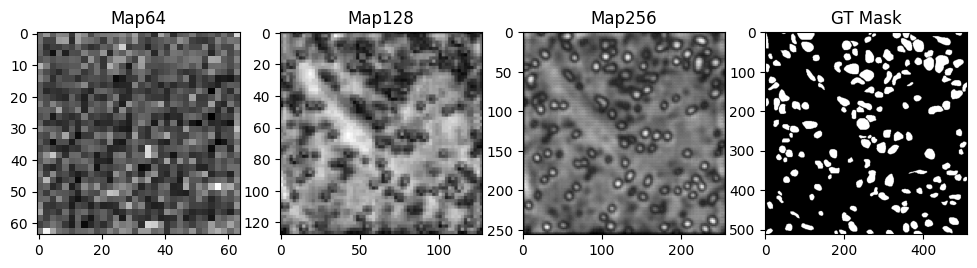

Storing new best ...


Training loss: 0.8854, Training Custom loss: 0.6741, Training Dice loss: 0.2448, Hloss: 0.2113 for step: 15: 100%|██████████| 15/15 



 Epoch 5: Train loss: 0.7810, Validation Loss: 0.9578, Train Dice: 0.7903, Validation Dice: 0.5336, Train Custom Loss: 0.5570, Train Hloss: 0.2240


Training loss: 0.8282, Training Custom loss: 0.6328, Training Dice loss: 0.2201, Hloss: 0.1954 for step: 15: 100%|██████████| 15/15 



 Epoch 6: Train loss: 0.7339, Validation Loss: 0.8577, Train Dice: 0.8032, Validation Dice: 0.5966, Train Custom Loss: 0.5228, Train Hloss: 0.2111
Storing new best ...


Training loss: 0.7730, Training Custom loss: 0.5714, Training Dice loss: 0.1988, Hloss: 0.2016 for step: 15: 100%|██████████| 15/15 



 Epoch 7: Train loss: 0.6865, Validation Loss: 0.8146, Train Dice: 0.8224, Validation Dice: 0.6245, Train Custom Loss: 0.4804, Train Hloss: 0.2062
Storing new best ...


Training loss: 0.7181, Training Custom loss: 0.5162, Training Dice loss: 0.1798, Hloss: 0.2019 for step: 15: 100%|██████████| 15/15 



 Epoch 8: Train loss: 0.6310, Validation Loss: 0.7829, Train Dice: 0.8463, Validation Dice: 0.6383, Train Custom Loss: 0.4349, Train Hloss: 0.1961
Storing new best ...


Training loss: 0.6937, Training Custom loss: 0.4751, Training Dice loss: 0.1725, Hloss: 0.2186 for step: 15: 100%|██████████| 15/15 



 Epoch 9: Train loss: 0.6137, Validation Loss: 0.7644, Train Dice: 0.8497, Validation Dice: 0.6538, Train Custom Loss: 0.4213, Train Hloss: 0.1924


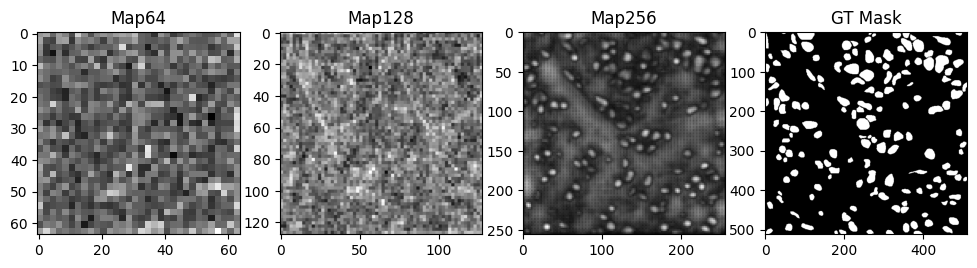

Storing new best ...


Training loss: 0.6971, Training Custom loss: 0.4797, Training Dice loss: 0.1568, Hloss: 0.2175 for step: 15: 100%|██████████| 15/15 



 Epoch 10: Train loss: 0.6176, Validation Loss: 0.7127, Train Dice: 0.8482, Validation Dice: 0.6950, Train Custom Loss: 0.4221, Train Hloss: 0.1956
Storing new best ...


Training loss: 0.6191, Training Custom loss: 0.4314, Training Dice loss: 0.1494, Hloss: 0.1877 for step: 15: 100%|██████████| 15/15 



 Epoch 11: Train loss: 0.5767, Validation Loss: 0.6723, Train Dice: 0.8622, Validation Dice: 0.7281, Train Custom Loss: 0.3890, Train Hloss: 0.1877
Storing new best ...


Training loss: 0.5735, Training Custom loss: 0.3919, Training Dice loss: 0.1430, Hloss: 0.1816 for step: 15: 100%|██████████| 15/15 



 Epoch 12: Train loss: 0.5675, Validation Loss: 0.6469, Train Dice: 0.8666, Validation Dice: 0.7441, Train Custom Loss: 0.3828, Train Hloss: 0.1847
Storing new best ...


Training loss: 0.5556, Training Custom loss: 0.3888, Training Dice loss: 0.1387, Hloss: 0.1668 for step: 15: 100%|██████████| 15/15 



 Epoch 13: Train loss: 0.5463, Validation Loss: 0.7120, Train Dice: 0.8755, Validation Dice: 0.6889, Train Custom Loss: 0.3647, Train Hloss: 0.1816


Training loss: 0.5700, Training Custom loss: 0.3902, Training Dice loss: 0.1290, Hloss: 0.1797 for step: 15: 100%|██████████| 15/15 



 Epoch 14: Train loss: 0.5567, Validation Loss: 0.6966, Train Dice: 0.8705, Validation Dice: 0.6950, Train Custom Loss: 0.3745, Train Hloss: 0.1821


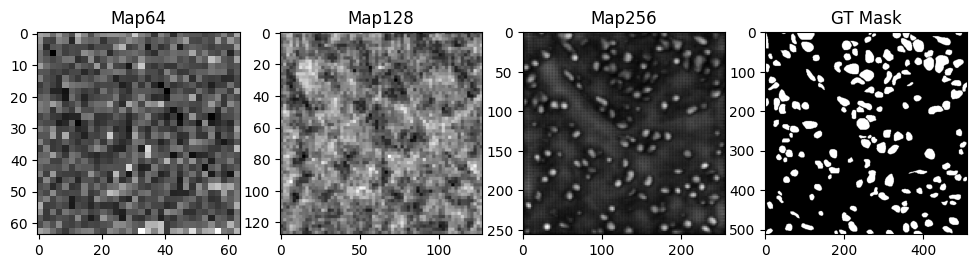

Training loss: 0.5360, Training Custom loss: 0.3783, Training Dice loss: 0.1393, Hloss: 0.1577 for step: 15: 100%|██████████| 15/15 



 Epoch 15: Train loss: 0.5504, Validation Loss: 0.6769, Train Dice: 0.8707, Validation Dice: 0.7101, Train Custom Loss: 0.3705, Train Hloss: 0.1799


Training loss: 0.5473, Training Custom loss: 0.3636, Training Dice loss: 0.1353, Hloss: 0.1837 for step: 15: 100%|██████████| 15/15 



 Epoch 16: Train loss: 0.5585, Validation Loss: 0.6465, Train Dice: 0.8674, Validation Dice: 0.7406, Train Custom Loss: 0.3760, Train Hloss: 0.1825


Training loss: 0.5967, Training Custom loss: 0.4111, Training Dice loss: 0.1715, Hloss: 0.1856 for step: 15: 100%|██████████| 15/15 



 Epoch 17: Train loss: 0.5463, Validation Loss: 0.6286, Train Dice: 0.8728, Validation Dice: 0.7372, Train Custom Loss: 0.3693, Train Hloss: 0.1770


Training loss: 0.6136, Training Custom loss: 0.4300, Training Dice loss: 0.1837, Hloss: 0.1837 for step: 15: 100%|██████████| 15/15 



 Epoch 18: Train loss: 0.5689, Validation Loss: 0.7625, Train Dice: 0.8651, Validation Dice: 0.6385, Train Custom Loss: 0.3883, Train Hloss: 0.1806


Training loss: 0.6401, Training Custom loss: 0.4485, Training Dice loss: 0.1953, Hloss: 0.1917 for step: 15: 100%|██████████| 15/15 



 Epoch 19: Train loss: 0.5539, Validation Loss: 0.9487, Train Dice: 0.8709, Validation Dice: 0.5304, Train Custom Loss: 0.3726, Train Hloss: 0.1812


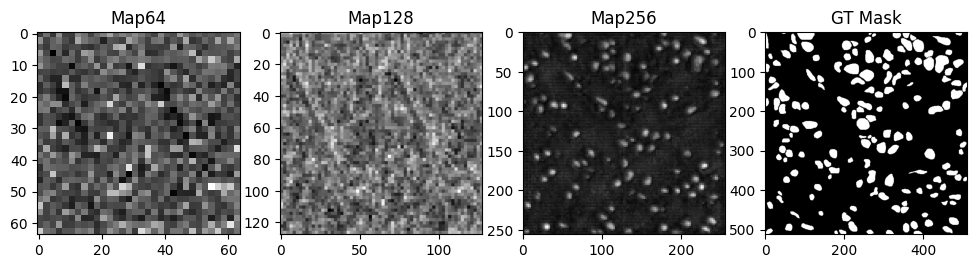

Training loss: 0.5944, Training Custom loss: 0.4087, Training Dice loss: 0.1666, Hloss: 0.1856 for step: 15: 100%|██████████| 15/15 



 Epoch 20: Train loss: 0.5450, Validation Loss: 1.1546, Train Dice: 0.8737, Validation Dice: 0.4160, Train Custom Loss: 0.3670, Train Hloss: 0.1780


Training loss: 0.6190, Training Custom loss: 0.4404, Training Dice loss: 0.1519, Hloss: 0.1787 for step: 15: 100%|██████████| 15/15 



 Epoch 21: Train loss: 0.5772, Validation Loss: 0.9498, Train Dice: 0.8647, Validation Dice: 0.5276, Train Custom Loss: 0.3929, Train Hloss: 0.1843


Training loss: 0.6948, Training Custom loss: 0.5100, Training Dice loss: 0.1648, Hloss: 0.1848 for step: 15: 100%|██████████| 15/15 



 Epoch 22: Train loss: 0.6065, Validation Loss: 0.6687, Train Dice: 0.8487, Validation Dice: 0.6972, Train Custom Loss: 0.4154, Train Hloss: 0.1911


Training loss: 0.6848, Training Custom loss: 0.4922, Training Dice loss: 0.1527, Hloss: 0.1926 for step: 15: 100%|██████████| 15/15 



 Epoch 23: Train loss: 0.5862, Validation Loss: 0.6495, Train Dice: 0.8566, Validation Dice: 0.7219, Train Custom Loss: 0.3946, Train Hloss: 0.1916


Training loss: 0.5623, Training Custom loss: 0.3824, Training Dice loss: 0.1174, Hloss: 0.1800 for step: 15: 100%|██████████| 15/15 



 Epoch 24: Train loss: 0.5348, Validation Loss: 0.6097, Train Dice: 0.8749, Validation Dice: 0.7454, Train Custom Loss: 0.3545, Train Hloss: 0.1803


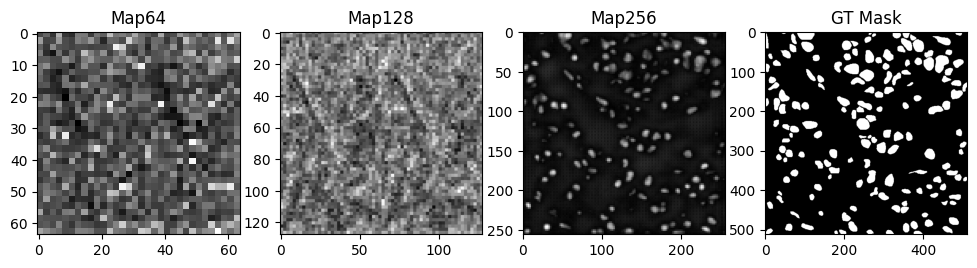

Storing new best ...


Training loss: 0.4883, Training Custom loss: 0.3252, Training Dice loss: 0.1028, Hloss: 0.1631 for step: 15: 100%|██████████| 15/15 



 Epoch 25: Train loss: 0.4781, Validation Loss: 0.6063, Train Dice: 0.8974, Validation Dice: 0.7421, Train Custom Loss: 0.3111, Train Hloss: 0.1670


Training loss: 0.4376, Training Custom loss: 0.2917, Training Dice loss: 0.0981, Hloss: 0.1459 for step: 15: 100%|██████████| 15/15 



 Epoch 26: Train loss: 0.4468, Validation Loss: 0.5892, Train Dice: 0.9072, Validation Dice: 0.7553, Train Custom Loss: 0.2859, Train Hloss: 0.1609
Storing new best ...


Training loss: 0.4207, Training Custom loss: 0.2794, Training Dice loss: 0.0975, Hloss: 0.1413 for step: 15: 100%|██████████| 15/15 



 Epoch 27: Train loss: 0.4350, Validation Loss: 0.6031, Train Dice: 0.9125, Validation Dice: 0.7424, Train Custom Loss: 0.2737, Train Hloss: 0.1613


Training loss: 0.4451, Training Custom loss: 0.2897, Training Dice loss: 0.1015, Hloss: 0.1555 for step: 15: 100%|██████████| 15/15 



 Epoch 28: Train loss: 0.4222, Validation Loss: 0.6011, Train Dice: 0.9157, Validation Dice: 0.7376, Train Custom Loss: 0.2667, Train Hloss: 0.1555


Training loss: 0.4096, Training Custom loss: 0.2690, Training Dice loss: 0.0892, Hloss: 0.1406 for step: 15: 100%|██████████| 15/15 



 Epoch 29: Train loss: 0.4197, Validation Loss: 0.6004, Train Dice: 0.9173, Validation Dice: 0.7381, Train Custom Loss: 0.2627, Train Hloss: 0.1570


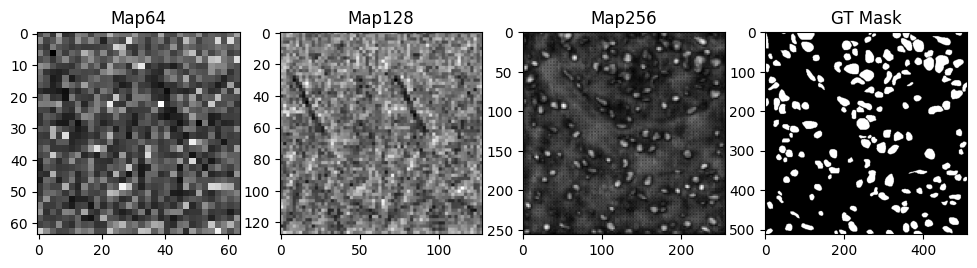

Training loss: 0.4184, Training Custom loss: 0.2764, Training Dice loss: 0.0856, Hloss: 0.1420 for step: 15: 100%|██████████| 15/15 



 Epoch 30: Train loss: 0.4119, Validation Loss: 0.5883, Train Dice: 0.9189, Validation Dice: 0.7486, Train Custom Loss: 0.2568, Train Hloss: 0.1551


Training loss: 0.3996, Training Custom loss: 0.2604, Training Dice loss: 0.0813, Hloss: 0.1392 for step: 15: 100%|██████████| 15/15 



 Epoch 31: Train loss: 0.4128, Validation Loss: 0.5786, Train Dice: 0.9202, Validation Dice: 0.7564, Train Custom Loss: 0.2552, Train Hloss: 0.1576
Storing new best ...


Training loss: 0.4151, Training Custom loss: 0.2589, Training Dice loss: 0.0753, Hloss: 0.1561 for step: 15: 100%|██████████| 15/15 



 Epoch 32: Train loss: 0.4166, Validation Loss: 0.5900, Train Dice: 0.9200, Validation Dice: 0.7499, Train Custom Loss: 0.2562, Train Hloss: 0.1604


Training loss: 0.3955, Training Custom loss: 0.2384, Training Dice loss: 0.0632, Hloss: 0.1571 for step: 14:  93%|█████████▎| 14/15 

KeyboardInterrupt: 

In [ ]:
history = model_wrapper.fit(
    train_dataset,
    test_dataset,
    epochs=60
)

In [ ]:
m = model_wrapper.model

In [ ]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 518, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 256, 256, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
# custom_objects = {'InstanceNormalization': InstanceNormalization, 'DWT': DWT}
trained_model = model_wrapper.best_model['model']
trained_model.save('/content/drive/MyDrive/ug26_3/Models/Segmentation/new_tnbc_21june.h5')
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ug26_3/Models/Segmentation/UNET_TNBC(NEW)_100_epoch.h5',custom_objects = {'GroupNormalization': GroupNormalization, 'GraphAttentionLayer':GraphAttentionLayer,'SqueezeExcitation':SqueezeExcitation})

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ug26_3/Models/Segmentation/new_tnbc_21june.h5',custom_objects = {'GroupNormalization': GroupNormalization, 'GraphAttentionLayer':GraphAttentionLayer,'SqueezeExcitation':SqueezeExcitation})

ValueError: Cannot assign value to variable ' conv2d_1/kernel:0': Shape mismatch.The variable shape (1, 1, 2048, 2048), and the assigned value shape (1, 1, 2048, 512) are incompatible.

In [ ]:
preds,_,_,map1,map2,map3 = loaded_model.predict(tissue)

1/1 [==============================] - 66s 66s/step


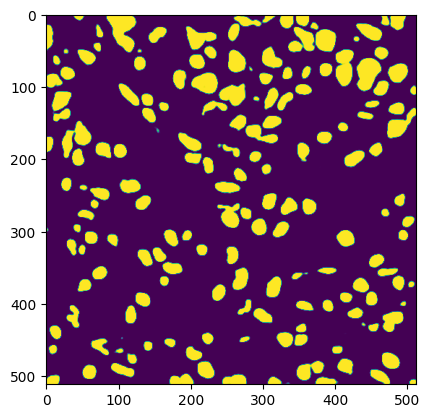

In [ ]:
plt.imshow(preds[0])
plt.show()

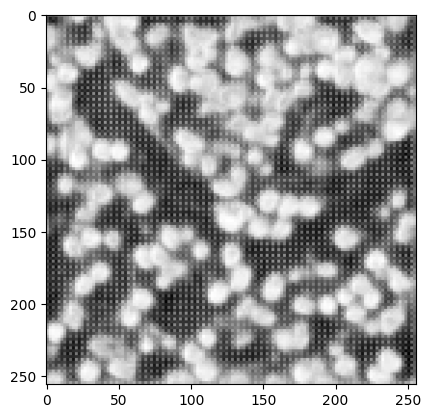

In [ ]:
plt.imshow(map3[0],cmap ='gray')
plt.show()

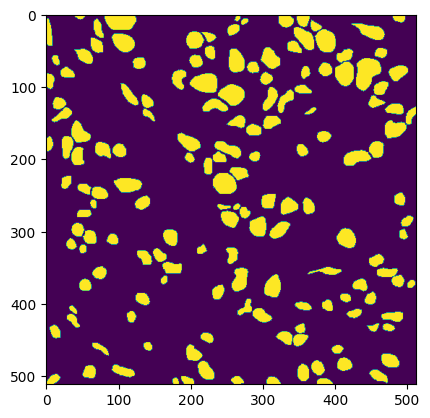

In [ ]:
plt.imshow(mask[0])
plt.show()

In [ ]:
_model = tf.keras.Model(loaded_model.input, loaded_model.get_layer('conv1/relu').output)
feat_64 = _model(tissue)
mask_512 = mask

In [ ]:
_feat1 = tf.random.uniform((3, 128, 128, 256))
_mask1 = tf.ones((3,512,512,1))

def f(feat, gt):
    """
    feat: (B x 128 x 128 x c)
    gt: (B x 512 x 512 x 1)
    """
    gt = tf.cast(gt > 0.5, dtype = tf.float32)
    temp_sum = lambda x : tf.reduce_sum(tf.reduce_sum(x, axis = 1), axis = 1)

    factor = gt.shape[1] // feat.shape[1]
    gt_max_pool = AveragePooling2D((factor, factor))(gt) # b x 128 x 128 x 1
    ugt_max_pool = AveragePooling2D((factor, factor))(1-gt)
    # print(gt_max_pool.shape)
    masked_feat = feat * gt_max_pool
    umasked_feat = feat * ugt_max_pool # b x 128 x 128 x c
    # print(masked_feat.shape)
    sum_masked_feat = temp_sum(masked_feat) # b x c
    usum_masked_feat = temp_sum(umasked_feat)
    sum_feat = temp_sum(feat)
    # print(sum_masked_feat.shape)
    sum_gt_max_pool = temp_sum(gt_max_pool) # b x 1
    usum_gt_max_pool = temp_sum(ugt_max_pool)
    total_pixel =  (feat.shape[1]*feat.shape[2])
    # print(sum_gt_max_pool.shape)
    mean_masked_feat = sum_masked_feat / sum_gt_max_pool # b x c
    umean_masked_feat = usum_masked_feat / usum_gt_max_pool
    mean_feat = sum_feat / total_pixel
    # print(mean_masked_feat.shape)

    mom4_feat = temp_sum(((feat - tf.expand_dims(tf.expand_dims(mean_feat, axis = 1), axis = 2)))**4) / total_pixel
    mom3_feat = temp_sum(((feat - tf.expand_dims(tf.expand_dims(mean_feat, axis = 1), axis = 2)))**3) / total_pixel

    mom_mask_feat = temp_sum(((masked_feat - tf.expand_dims(tf.expand_dims(mean_masked_feat, axis = 1), axis = 2)) * gt_max_pool)**4) / sum_gt_max_pool
    umom_mask_feat = temp_sum(((umasked_feat - tf.expand_dims(tf.expand_dims(umean_masked_feat, axis = 1), axis = 2)) * ugt_max_pool)**4) / usum_gt_max_pool

    var_channel = tf.math.reduce_variance(feat, axis = [1, 2])
    # print(var_channel.shape,var_mask_feat.shape)

    # pruned_feat = feat * tf.maximum(tf.expand_dims(tf.expand_dims(var_channel, axis = 1), axis = 2) - 0.01 , 0.0)
    mean_variance_per_sample = tf.reduce_mean(var_channel, axis = -1, keepdims = True)
    mean_variance_per_sample__ =  tf.expand_dims(tf.expand_dims(mean_variance_per_sample, axis = 1), axis = 2)
    print(mean_variance_per_sample__)
    pruned_feat = feat * tf.where(tf.expand_dims(tf.expand_dims(var_channel, axis = 1), axis = 2) >= mean_variance_per_sample__ , 1.0, 0.0)
    print(tf.reduce_sum(pruned_feat))
    pvar_channel = tf.math.reduce_variance(pruned_feat, axis = [1, 2])

    mean_mom_mask_feat = tf.reduce_mean(mom_mask_feat, axis = -1)
    umean_mom_mask_feat = tf.reduce_mean(umom_mask_feat, axis = -1)

    int_class_dist = -tf.keras.losses.CosineSimilarity(reduction="none")(mean_masked_feat, umean_masked_feat)


    return mean_mom_mask_feat, umean_mom_mask_feat, int_class_dist, masked_feat, umasked_feat, mean_masked_feat, umean_masked_feat, var_channel, pvar_channel, pruned_feat,mom_mask_feat,umom_mask_feat,mom3_feat,mom4_feat


In [ ]:
_mean_mom_mask_feat, _umean_mom_mask_feat, _int_class_dist,_masked_feat, _umasked_feat, _mean_masked_feat, _umean_masked_feat, _var_channel, p, pf,_mom_mask_feat,_umom_mask_feat,_mom3_feat,_mom4_feat  = f(feat_64, mask_512)
__mean_mom_mask_feat, __umean_mom_mask_feat, __int_class_dist,__masked_feat, __umasked_feat, __mean_masked_feat, __umean_masked_feat, __var_channel, _p, _pf,__mom_mask_feat,__umom_mask_feat,__mom3_feat,__mom4_feat = f(pf, mask_512)

tf.Tensor(
[[[[0.01452334]]]


 [[[0.01367805]]]], shape=(2, 1, 1, 1), dtype=float32)
tf.Tensor(197826.86, shape=(), dtype=float32)
tf.Tensor(
[[[[0.0101328 ]]]


 [[[0.00927849]]]], shape=(2, 1, 1, 1), dtype=float32)
tf.Tensor(197826.86, shape=(), dtype=float32)


In [ ]:
print(_mean_mom_mask_feat, _umean_mom_mask_feat, _int_class_dist)

tf.Tensor([0.00247938 0.00206838], shape=(2,), dtype=float32) tf.Tensor([0.00131714 0.00166404], shape=(2,), dtype=float32) tf.Tensor([0.8734102 0.8199851], shape=(2,), dtype=float32)


In [ ]:
print(__mean_mom_mask_feat, __umean_mom_mask_feat, __int_class_dist)

tf.Tensor([0.00222803 0.00162348], shape=(2,), dtype=float32) tf.Tensor([0.0010415 0.0013602], shape=(2,), dtype=float32) tf.Tensor([0.86997855 0.8118298 ], shape=(2,), dtype=float32)


In [ ]:
print(_var_channel.shape)

(2, 512)


In [ ]:
# threshold = 0.0136780
# x = _var_channel[1].shape[0]
# y = _var_channel[1]
# plt.figure(figsize = (20, 5))
# plt.plot(_var_channel[1], label = "unpruned mask")
# plt.axhline(y=threshold, color='r', linestyle='--')
# plt.fill_between(x, y, threshold, where=(y >= threshold), facecolor='lightgreen', interpolate=True)
# plt.fill_between(x, y, threshold, where=(y < threshold), facecolor='lightcoral', interpolate=True)
# # plt.plot(__umean_masked_feat[1][:100], label = "pruned umask")
# plt.legend()
# plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D

def compute_average_variance_across_samples(test_dataset,model, batch_size=2):
    """
    Compute the average variance per channel across all samples and the average
    of the average of variance of all channels in one sample across all samples.

    Args:
    test_dataset: TensorFlow dataset containing test samples.
    batch_size: Batch size for processing the dataset.

    Returns:
    avg_var_per_channel: Average variance per channel across all samples.
    avg_avg_var_per_sample: Average of the average variance per sample across all samples.
    """

    # Initialize accumulators
    avg_var_per_channel_sum = tf.zeros((2, 320)) # Initialize sum for average variance per channel
    avg_avg_var_per_sample_sum = 0.0  # Initialize sum for average of average variance per sample
    num_samples = 0  # Counter for total number of samples

    # Iterate over the dataset
    test_iter = iter(test_dataset)
    for _ in range(10):
        tissue_batch, mask_batch = next(test_iter)  # Extract the tissue tensor from the batch
        num_samples += tissue_batch.shape[0]  # Update total number of samples
        feat, _, _, _, _, _, c1, c2, c3 = model(tissue_batch)
        # Step 1: Calculate variance per channel across spatial dimensions for each batch
        var_per_channel_batch = tf.math.reduce_variance(c3, axis=[1, 2])
        print(var_per_channel_batch.shape)
        # Step 2: Accumulate sum for average variance per channel across all samples
        avg_var_per_channel_sum += tf.reduce_sum(var_per_channel_batch, axis=0)

        # Step 3: Calculate average of the average variance per sample across the batch
        avg_avg_var_per_sample_sum += tf.reduce_sum(tf.reduce_mean(var_per_channel_batch, axis=-1))

    # Step 4: Calculate final average variance per channel and average of average variance per sample
    avg_var_per_channel = avg_var_per_channel_sum / num_samples
    avg_avg_var_per_sample = avg_avg_var_per_sample_sum / num_samples

    return avg_var_per_channel, avg_avg_var_per_sample

# Example usage assuming 'test_dataset' is your TensorFlow dataset
# Replace this with your actual test dataset initialization
# test_dataset = tf.data.Dataset.from_tensor_slices((tf.random.uniform((30, 128, 128, 256)), tf.random.uniform((30, 512, 512, 1))))

# Calculate average variance per channel and average of the average variance per sample across all samples
avg_var_per_channel, avg_avg_var_per_sample = compute_average_variance_across_samples(test_dataset, m)

print("Average variance per channel (across all samples):", avg_var_per_channel.numpy().shape)
print("Average of the average variance per sample (across all samples):", avg_avg_var_per_sample.numpy())

(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
(2, 320)
Average variance per channel (across all samples): (2, 320)
Average of the average variance per sample (across all samples): 0.006199991


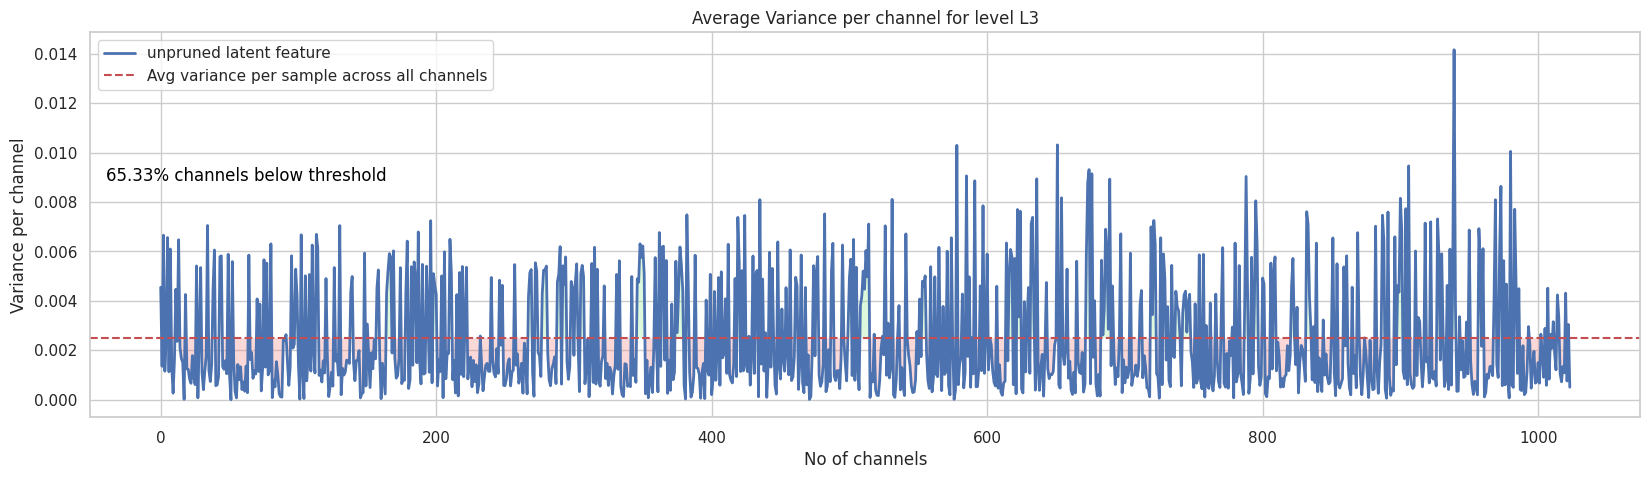

In [ ]:
import seaborn as sns
y = (avg_var_per_channel[0] + avg_var_per_channel[1])/2
x = np.arange(len(y))
threshold = 0.0024992882
plt.figure(figsize=(20, 5))

num_below_threshold = np.sum(y < threshold)
percentage_below_threshold = (num_below_threshold / len(y)) * 100

sns.set(style="whitegrid")
sns.lineplot(x=x, y=y, label="unpruned latent feature", lw=2)
plt.title("Average Variance per channel for level L3")
plt.axhline(y=threshold, color='r', linestyle='--', label='Avg variance per sample across all channels')
plt.fill_between(x, y, threshold, where=(y > threshold), facecolor='lightgreen', alpha=0.3)

plt.fill_between(x, y, threshold, where=(y < threshold), facecolor='lightcoral', alpha=0.3)
plt.xlabel("No of channels")
plt.ylabel("Variance per channel")
plt.text(0.01, 0.65, f'{percentage_below_threshold:.2f}% channels below threshold',
         fontsize=12, color='black', transform=plt.gca().transAxes, verticalalignment='top')


plt.legend()

plt.show()


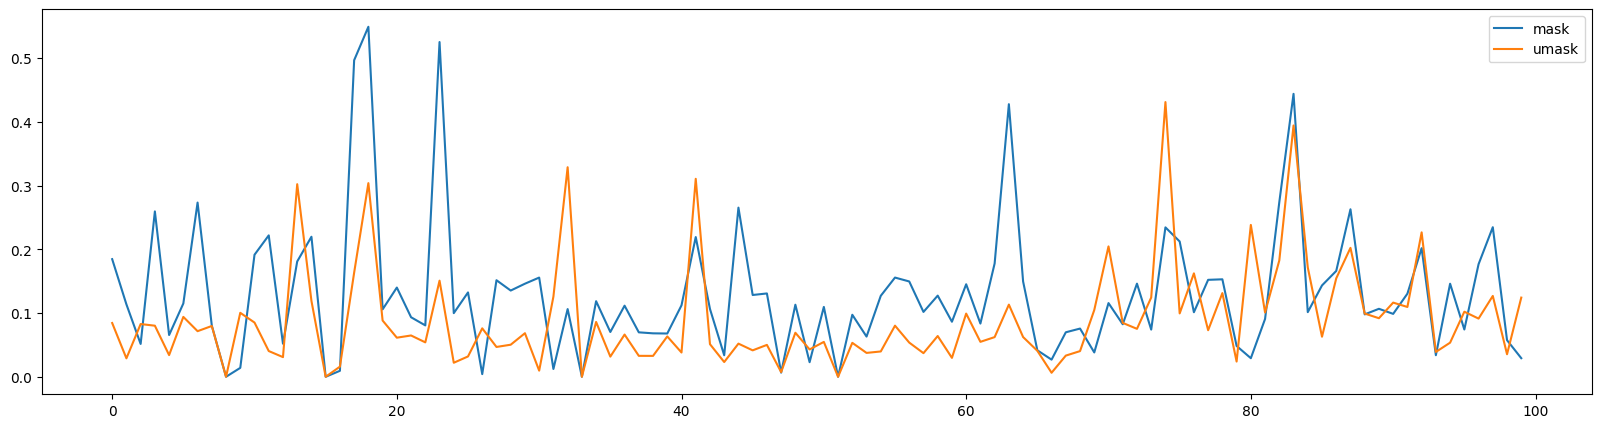

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(_mean_masked_feat[1][:100], label = "mask")
plt.plot(_umean_masked_feat[1][:100], label = "umask")
plt.legend()
plt.show()

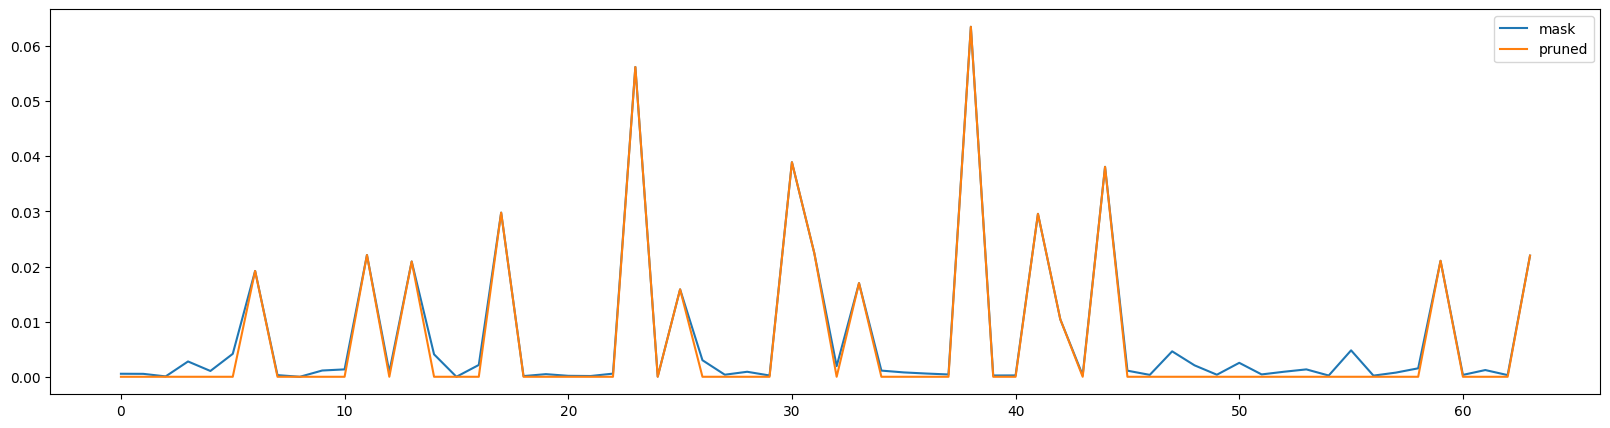

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(_var_channel[1][:100], label = "mask")
plt.plot(__var_channel[1][:100], label = "pruned")
plt.legend()
plt.show()

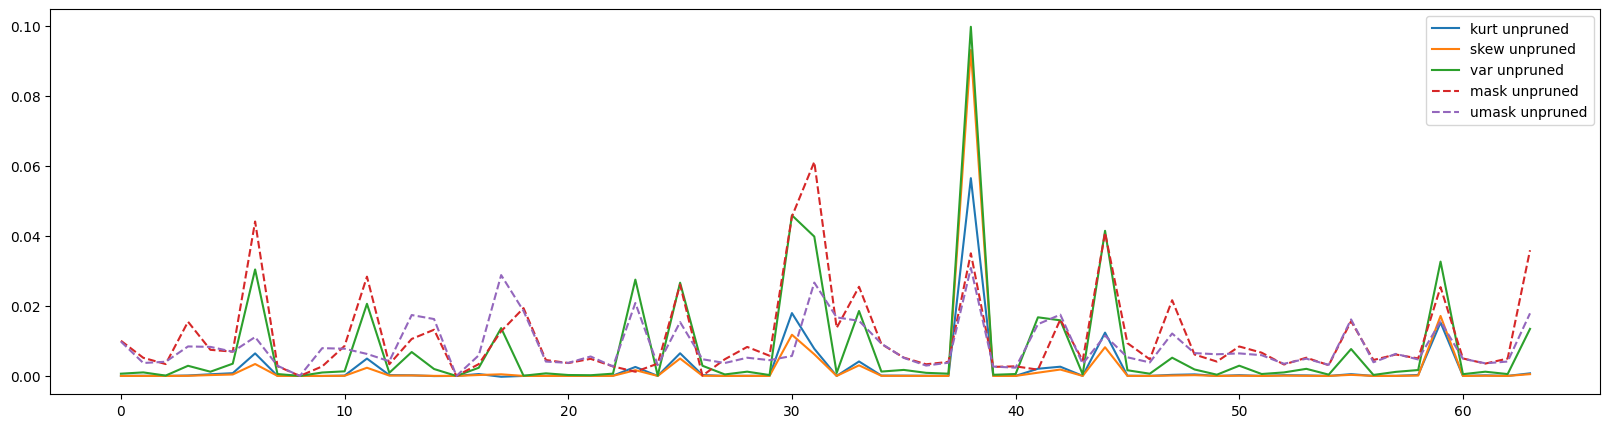

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(_mom3_feat[0][:100], label = "kurt unpruned")
plt.plot(_mom4_feat[0][:100], label = "skew unpruned")
plt.plot(_var_channel[0][:100], label = "var unpruned")

plt.plot(_mean_masked_feat[0][:100]/10, label = "mask unpruned", linestyle="--")
plt.plot(_umean_masked_feat[0][:100]/10, label = "umask unpruned", linestyle="--")
# plt.plot(__mom_feat[1][:100], label = "moment pruned")
# plt.plot(__var_channel[1][:100], label = "var pruned")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

def plot_3d_surface(grid):
    # Create a 256x256 grid of x and y values
    x = np.linspace(-5, 5, 256)  # 256 equally spaced points from -5 to 5
    y = np.linspace(-5, 5, 256)
    X, Y = np.meshgrid(x, y)  # Create grid of X and Y values

    # Compute the Z values (here using a function, you can modify this)
    Z = grid#np.sin(np.sqrt(X**2 + Y**2))

    # Create a 3D surface plot using plotly
    fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])

    # Update layout and add labels
    fig.update_layout(
        title='3D Surface Plot',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),width=1000,  # Width of the figure in pixels
    height=1000,  # Height of the figure in pixels
    margin=dict(l=0, r=0, b=0, t=0)
    )

    # Show the plot
    fig.show()

def plot_contour(grid_data,gt):
    """
    Plot a contour plot for a 2D grid.

    Parameters:
    grid_data (2D array): The input grid data (256x256).

    Returns:
    None (displays the plot)
    """

    factor = gt.shape[1] // grid_data.shape[1]
    gt = AveragePooling2D((factor, factor))(gt)[0] # b x 128 x 128 x 1
    # Create x and y coordinate arrays corresponding to the grid dimensions
    x = np.arange(0, grid_data.shape[0])
    y = np.arange(0, grid_data.shape[1])

    # Create meshgrid from x and y coordinates
    X, Y = np.meshgrid(x, y)

    # Plotting the contour plot
    plt.figure(figsize=(8, 8))  # Set the figure size (optional)
    contours = plt.contour(X, Y, grid_data, cmap='viridis')  # Create contour plot
    plt.colorbar(contours)  # Add color bar representing the contour levels
    plt.imshow(gt/1000,cmap='gray',alpha=0.5)
    plt.title('Contour Plot of 2D Grid')  # Set plot title
    plt.xlabel('X-coordinate')  # Set x-axis label
    plt.ylabel('Y-coordinate')  # Set y-axis label
    plt.show()  # Display the plot

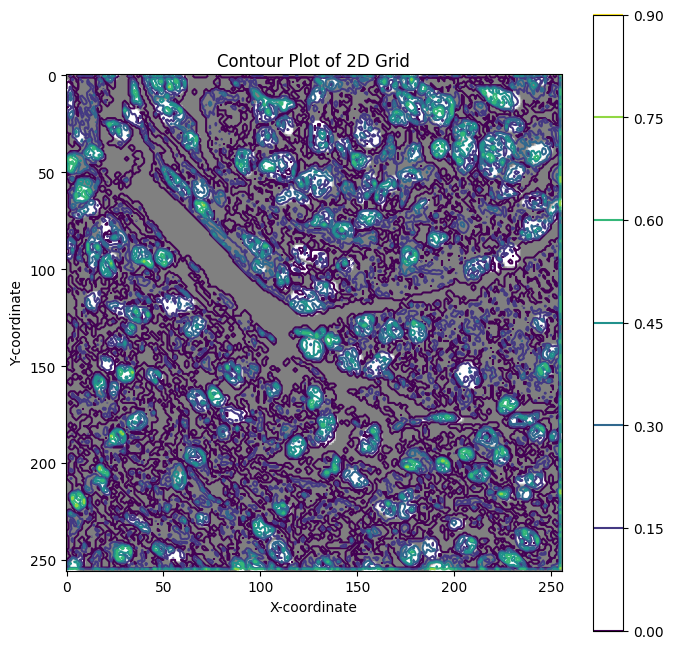

In [ ]:
plot_contour(feat_64[0,:,:,11],mask)

In [ ]:
from matplotlib.animation import FuncAnimation

def update_plot(frame, data, ax,gt):
    ax.clear()  # Clear previous plot
    grid_data = data[frame]  # Get grid data for the current frame
    x = np.arange(0, grid_data.shape[0])
    y = np.arange(0, grid_data.shape[1])
    X, Y = np.meshgrid(x, y)
    contours = ax.contour(X, Y, grid_data, cmap='viridis')  # Create contour plot
    ax.imshow(gt,cmap='gray',alpha=0.2)
    # ax.colorbar(contours)
    ax.set_title(f'Frame {frame}')  # Set title with frame index
    return contours,

def create_contour_animation(data, gt,indx,filename, fps):
    factor = gt.shape[1] // data[0].shape[1]
    gt = AveragePooling2D((factor, factor))(gt)[indx]
    fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axes
    ani = FuncAnimation(fig, update_plot, frames=len(data), fargs=(data, ax,gt),
                        interval=1000 // fps)  # Create animation
    ani.save(filename, writer='pillow')  # Save animation as GIF using Pillow writer

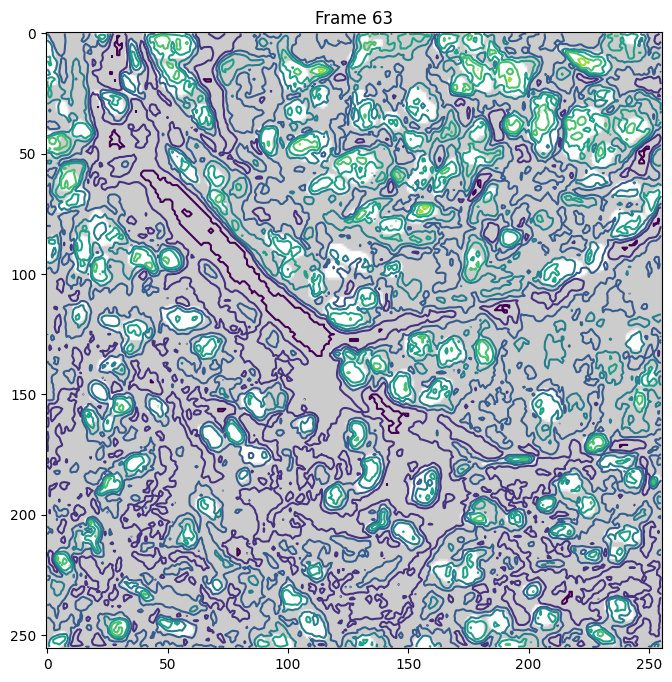

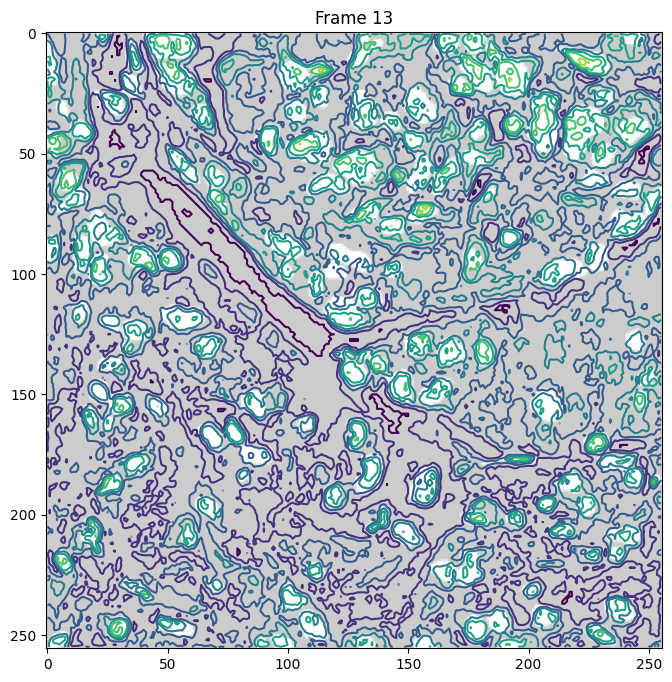

In [ ]:
indx = 0
create_contour_animation([feat_64[indx,:,:,i].numpy() for i in range(64)], mask, indx, filename='unpruned_contour_animation overlapped.gif', fps=1)
# create_contour_animation([pf[indx,:,:,i].numpy() for i in range(64)], mask, indx,filename='pruned_contour_animation.gif', fps=1)
create_contour_animation([pf[indx,:,:,i].numpy() for i in range(64) if np.sum(pf[0,:,:,i])>0.0001], mask, indx, filename='only_pruned_contour_animation overlapped.gif', fps=1)

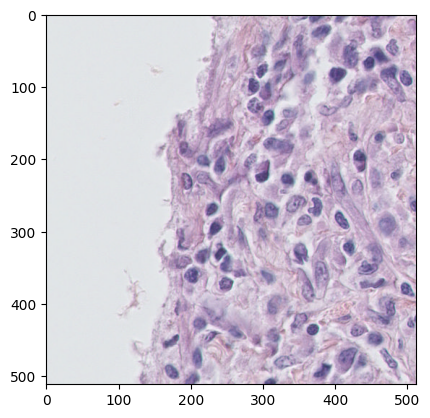

In [ ]:
plt.imshow(tissue[1])

In [ ]:
_ng = NewGraphLayer(128)

In [ ]:
_graph_feat = _ng(MaxPooling2D((2,2))(feat_64))

In [ ]:
_spt_atten = tf.reduce_mean(MaxPooling2D((2,2))(feat_64),axis=-1)

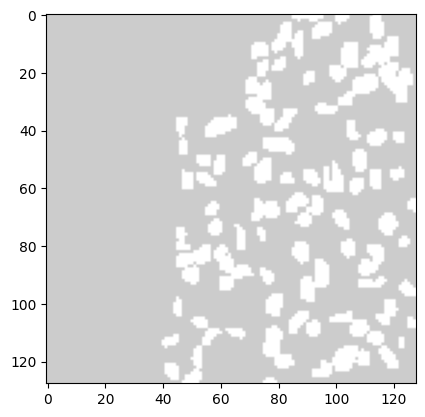

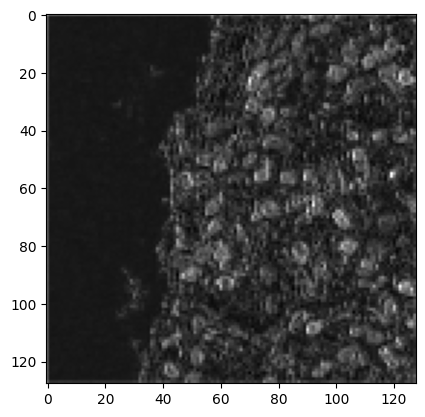

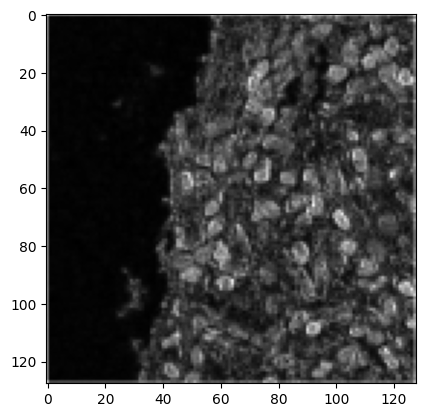

In [ ]:
plt.imshow(MaxPooling2D((4,4))(mask)[1],alpha=0.2,cmap='gray')
plt.show()
plt.imshow(_graph_feat[1],cmap='gray')
plt.show()
plt.imshow(_spt_atten[1],cmap='gray')
plt.show()

In [ ]:
_bin_graph_feat = tf.where(_graph_feat>tf.reduce_mean(_graph_feat,axis=[1,2],keepdims=True)*1.5,1.0,0.0)

In [ ]:
plt.title('GT')
plt.imshow(MaxPooling2D((4,4))(mask)[0],cmap='gray')
plt.show()
plt.title('preds')
plt.imshow(MaxPooling2D((4,4))(preds)[0],cmap='gray')
plt.show()
plt.title('GMAP')
plt.imshow(_graph_feat[0],cmap='gray')
plt.show()
plt.title('Thr GMAP')
plt.imshow(_bin_graph_feat[0],cmap='gray')
plt.show()
plt.title('SoftMAP')
plt.imshow(_spt_atten[0],cmap='gray')
plt.show()

In [ ]:
import cv2
def sharpen(image, ddepth=-1):
  """
  Sharpens a 2D single channel image.

  Args:
    image: A 2D NumPy array representing the image.
    ddepth: The depth of the output image.

  Returns:
    A new 2D NumPy array with sharpened image.
  """

  # Create the sharpening kernel.
  kernel = np.array(
       [
           [-1, -1, -1],
           [-1, 8, -1],
            [-1, -1, -1]
           ])

  # Apply the sharpening kernel to the image using the filter2D function.
  image_sharpened = cv2.filter2D(src=image, ddepth=ddepth, kernel=kernel)

  return image_sharpened

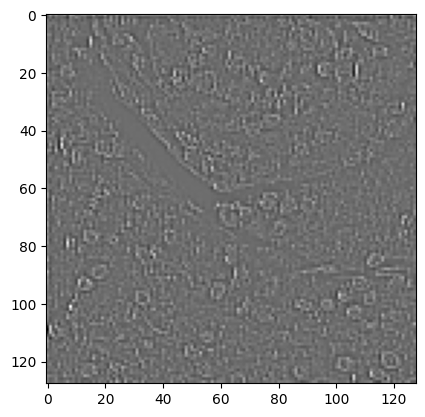

In [ ]:
plt.imshow(sharpen(_graph_feat[0].numpy(),-1),cmap='gray')

In [ ]:
iou_calculator = IOU()

def generate_masks(model, image_batch):
  masks_batch, _, _, _, _, _ = model.predict(image_batch)
  return masks_batch

total_iou = 0
# Define a function to calculate IoU for a batch of images and masks

    # Predict segmentation masks using the loaded model
test_data_iter = iter(test_dataset)
for _ in range(10):
    image_batch, mask_batch = next(test_data_iter)
    generated_masks_batch = generate_masks(trained_model, image_batch)
    total_iou += iou_calculator(generated_masks_batch, mask_batch)


print("Average IoU:", total_iou/10)

1/1 [==============================] - 1s 1s/step
Average IoU: tf.Tensor(0.64032364, shape=(), dtype=float32)


In [ ]:
class F1ScoreCalculator:
    def __init__(self):
        pass

    def calculate_f1_score(self, y_true, y_pred):
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])

        # Convert predictions to binary values using thresholding
        y_pred_binary = tf.cast(y_pred_flat > 0.5, dtype=tf.float32)

        # Calculate F1 score
        f1 = f1_score(y_true_flat.numpy(), y_pred_binary.numpy())

        return f1

    def __call__(self, y_true, y_pred):
        return self.calculate_f1_score(y_true, y_pred)

f1_score_calculator = F1ScoreCalculator()

def generate_masks(model, image_batch):
    masks_batch, _, _, _, _, _ = model.predict(image_batch)
    return masks_batch

total_f1_score = 0

test_data_iter = iter(test_dataset)
for _ in range(10):
    image_batch, mask_batch = next(test_data_iter)
    generated_masks_batch = generate_masks(trained_model, image_batch)

    # Threshold the generated masks
    generated_masks_batch_thresholded = (generated_masks_batch > 0.5).astype(np.float32)

    total_f1_score += f1_score_calculator(generated_masks_batch_thresholded, mask_batch)

print("Average F1 Score:", total_f1_score / 10)


1/1 [==============================] - 1s 1s/step
Average F1 Score: 0.781551956569095


In [ ]:
preds, s3, s4,map_up1,map_up2,map_up3 = loaded_model.predict(tissue)

1/1 [==============================] - 45s 45s/step


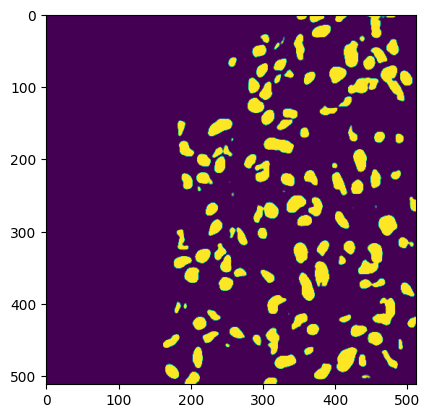

In [ ]:
plt.imshow(preds[1])
plt.show()